##### Tweak 1.6 — OneCycle Learning Rate

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from torch.optim.lr_scheduler import OneCycleLR

In [2]:
# reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device selection
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'PyTorch version : {torch.__version__}')
print(f'Device          : {device}')
if device.type == 'cuda':
    print(f'GPU             : {torch.cuda.get_device_name(0)}')
    print(f'VRAM            : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

PyTorch version : 2.9.0
Device          : mps


In [3]:
def get_cifar10_subsets(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    full_test  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_subset = Subset(full_train, range(5000))
    val_subset   = Subset(full_test,  range(1000))

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, full_train.classes

In [4]:
train_loader, val_loader, classes = get_cifar10_subsets()

print(f'Training samples   : {len(train_loader.dataset)}')
print(f'Validation samples : {len(val_loader.dataset)}')

Training samples   : 5000
Validation samples : 1000


In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=15, scheduler=None):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_weights = None

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if scheduler:
                scheduler.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc  = 100.0 * correct / total

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch:3d}/{epochs}  |  Train Loss: {train_loss:.4f}  Acc: {train_acc:.2f}%  |  Val Loss: {val_loss:.4f}  Acc: {val_acc:.2f}%')

    if best_weights:
        model.load_state_dict(best_weights)
    print(f'\nBest validation accuracy: {best_val_acc:.2f}%')
    return history

In [7]:
def plot_history(history, title='Training History'):
    epochs = range(1, len(history['train_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    ax1.plot(epochs, history['val_loss'],   's-', label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} — Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(epochs, history['train_acc'], 'o-', label='Train Acc')
    ax2.plot(epochs, history['val_acc'],   's-', label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} — Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

#### 2.1 Build Model 1.6 — Deep CNN + OneCycleLR

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0.1):
        super().__init__()
        
        # Main path
        # If stride > 1, this acts as the downsampler
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # Spatial Dropout (drops entire channels)
        self.dropout = nn.Dropout2d(p=dropout_prob)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut path (Skip Connection)
        self.shortcut = nn.Sequential()
        
        # If dimensions change (stride > 1) or channels change, adjust identity mapping
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity  # The "Skip Connection"
        out = self.relu(out)
        
        return out

class DeepCNN_Res(nn.Module):
    """
    Model 1.5: Residual Connections + Strided Convs + Spatial Dropout
    
    Structure:
    - Input: 3x32x32
    - Block 1: 64 filters (stride 1) -> 32x32 (No pooling yet)
               *Correction from 1.4: 1.4 had MaxPool at end of blocks. 
               Here we will downsample in Block 2 and 3, or maybe Block 1 too?
               Let's stick to 1.4 output sizes: 
               1.4: 32x32 -> Block1 -> 16x16 -> Block2 -> 8x8 -> Block3 -> 4x4
               So we need stride=2 in Block 1, 2, and 3? 
               Actually, standard ResNets often keep first size. 
               But to match 1.4 capacity progression, let's downsample at start of each block.
    """
    def __init__(self):
        super().__init__()
        
        # Block 1: 3 -> 64. Stride=2 effectively replaces MaxPool.
        # (3, 32, 32) -> (64, 16, 16)
        # Note: applying stride=2 on the very first conv layer on 32x32 is aggressive,
        # but matches the spatial reduction of 1.4 (which ended with MaxPool).
        # Let's use stride=1 for the first projection? 
        # No, 1.4 Block 1 output was 16x16. So stride=2 here is correct equivalent.
        # Wait, typical structure is usually a Stem/entry conv. 
        # Let's treat the first block as the stem + block combined.
        self.block1 = ResidualBlock(3, 64, stride=1) # Keep 32x32 initially? 
        # 1.4: Block 1 (stride 1 convs) -> MaxPool (32->16). 
        # So 1.5 Block 1 should output 16x16 if we replace MaxPool. 
        # Let's implicitly add a downsample-only block or integrate it.
        
        # Let's adjust: 
        # 1. Entry Conv (usually done): 3->64,
        # 2. ResBlock 64->64
        # 3. ResBlock 64->128 (downsample)
        # ...
        
        # To strictly follow "Replace Pool with Strided Conv in ONE block":
        # Block 1 (3->64): Stride 1 or 2? 
        # Let's try stride=1 for first layer to preserve info, then stride=2 for others?
        # Actually, user said: "Replace MaxPool with Strided Convolutions in the first layer of each block"
        # If we do that for Block 1 (channels 3->64), we go 32x32 -> 16x16 immediately.
        self.block1 = ResidualBlock(3, 64, stride=2)   # 32x32 -> 16x16
        self.block2 = ResidualBlock(64, 128, stride=2) # 16x16 -> 8x8
        self.block3 = ResidualBlock(128, 256, stride=2)# 8x8 -> 4x4
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

In [9]:
model = DeepCNN_Res().to(device)
print(model)
print(f'\nTrainable parameters: {count_parameters(model):,}')

DeepCNN_Res(
  (block1): ResidualBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (dropout): Dropout2d(p=0.1, inplace=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (dropout): Dropout2d(p=0.1, inplace=False)
    (conv2): Conv2d(128, 128,

In [10]:
EPOCHS = 15
LR = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# OneCycleLR Scheduler
scheduler = OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=EPOCHS)

print(f'Optimizer : Adam (OneCycleLR max_lr={0.001})')
print(f'Epochs    : {EPOCHS}')
print(f'Device    : {device}')
print('-' * 60)

start = time.time()
history = train_model(model, train_loader, val_loader, criterion,
                      optimizer, device, epochs=EPOCHS, scheduler=scheduler)
elapsed = time.time() - start
print(f'\nTraining time: {elapsed:.1f}s')

Optimizer : Adam (OneCycleLR max_lr=0.001)
Epochs    : 15
Device    : mps
------------------------------------------------------------


Epoch   1/15  |  Train Loss: 2.0184  Acc: 26.12%  |  Val Loss: 1.8583  Acc: 30.00%


Epoch   2/15  |  Train Loss: 1.6912  Acc: 38.96%  |  Val Loss: 1.6241  Acc: 37.60%


Epoch   3/15  |  Train Loss: 1.5327  Acc: 44.18%  |  Val Loss: 1.5759  Acc: 42.20%


Epoch   4/15  |  Train Loss: 1.3941  Acc: 49.18%  |  Val Loss: 1.9630  Acc: 35.70%


Epoch   5/15  |  Train Loss: 1.2895  Acc: 52.84%  |  Val Loss: 1.3559  Acc: 52.80%


Epoch   6/15  |  Train Loss: 1.1243  Acc: 60.54%  |  Val Loss: 1.5104  Acc: 47.40%


Epoch   7/15  |  Train Loss: 0.9604  Acc: 65.70%  |  Val Loss: 1.3179  Acc: 54.90%


Epoch   8/15  |  Train Loss: 0.8026  Acc: 72.18%  |  Val Loss: 1.2240  Acc: 56.70%


Epoch   9/15  |  Train Loss: 0.6102  Acc: 79.92%  |  Val Loss: 1.2634  Acc: 54.10%


Epoch  10/15  |  Train Loss: 0.4578  Acc: 86.00%  |  Val Loss: 1.3707  Acc: 53.90%


Epoch  11/15  |  Train Loss: 0.2911  Acc: 92.16%  |  Val Loss: 1.2964  Acc: 56.20%


Epoch  12/15  |  Train Loss: 0.1823  Acc: 96.46%  |  Val Loss: 1.3290  Acc: 57.10%


Epoch  13/15  |  Train Loss: 0.1255  Acc: 98.24%  |  Val Loss: 1.3334  Acc: 57.30%


Epoch  14/15  |  Train Loss: 0.1080  Acc: 98.72%  |  Val Loss: 1.3344  Acc: 57.70%


Epoch  15/15  |  Train Loss: 0.0950  Acc: 99.12%  |  Val Loss: 1.3262  Acc: 57.30%

Best validation accuracy: 57.70%

Training time: 32.9s


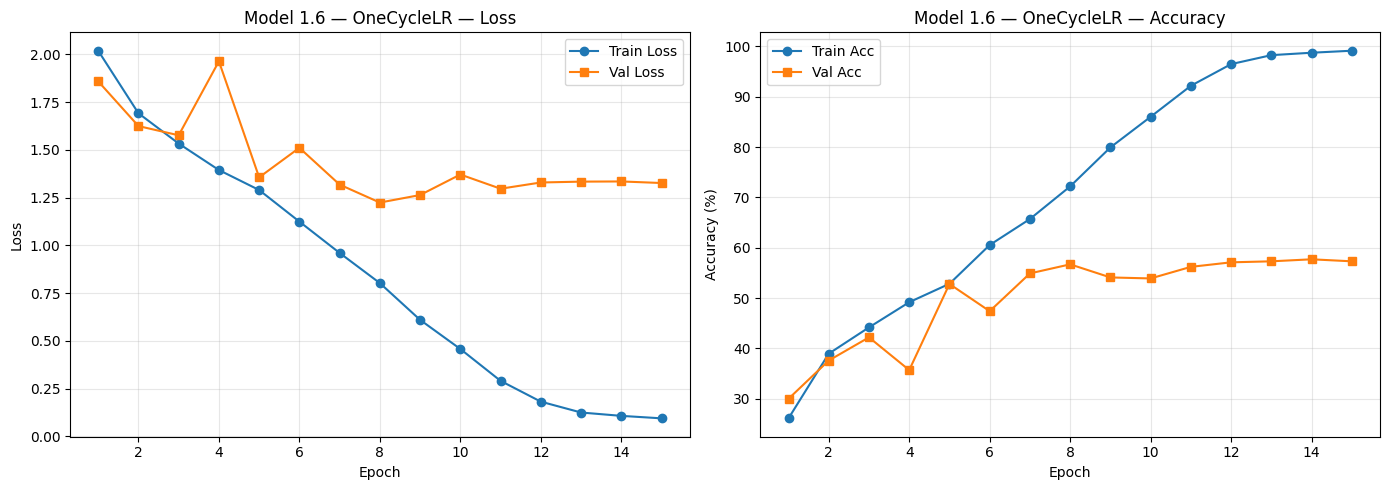

In [11]:
plot_history(history, title='Model 1.6 — OneCycleLR')

In [12]:
final_train_acc = history['train_acc'][-1]
final_val_acc   = history['val_acc'][-1]
peak_val_acc    = max(history['val_acc'])
gap             = final_train_acc - final_val_acc

print('=' * 50)
print('   MODEL 1.6 — RESULTS SUMMARY (OneCycleLR)')
print('=' * 50)
print(f'  Parameters       : {count_parameters(model):,}')
print(f'  Final Train Acc  : {final_train_acc:.2f}%')
print(f'  Final Val Acc    : {final_val_acc:.2f}%')
print(f'  Peak Val Acc     : {peak_val_acc:.2f}%')
print(f'  Train-Val Gap    : {gap:+.2f}%')
print('=' * 50)

   MODEL 1.6 — RESULTS SUMMARY (OneCycleLR)
  Parameters       : 1,190,922
  Final Train Acc  : 99.12%
  Final Val Acc    : 57.30%
  Peak Val Acc     : 57.70%
  Train-Val Gap    : +41.82%
